# Mastitis Detection System - Automated Features Only

This notebook implements a complete machine learning pipeline for automatic mastitis detection in dairy cattle using sensor data (temperature + ultrasound measurements) without manual inspection features.

**Pipeline Overview:**
1. Data Loading & Preprocessing
2. Feature Engineering (Asymmetry Metrics)
3. Train/Test Split (Stratified)
4. Model Training with Hyperparameter Optimization
5. Probability Calibration
6. Evaluation & Visualization
7. Model Persistence

DÉTECTION AUTOMATIQUE DE MASTITE - FEATURES AUTOMATIQUES UNIQUEMENT

📊 Taille initiale : (6600, 18)
❌ Valeurs manquantes :
Cow_ID                       0
Day                          0
Breed                        0
Months after giving birth    0
Previous_Mastits_status      0
IUFL                         0
EUFL                         0
IUFR                         0
EUFR                         0
IURL                         0
EURL                         0
IURR                         0
EURR                         0
Temperature                  0
Hardness                     0
Pain                         0
Milk_visibility              0
class1                       0
dtype: int64

✅ Après nettoyage : (6600, 18)

FEATURES UTILISÉES (DÉTECTION AUTOMATIQUE)

✅ Features automatiques retenues :
   • Breed
   • Months after giving birth
   • Previous_Mastits_status
   • Temperature
   • IUFL
   • EUFL
   • IUFR
   • EUFR
   • IURL
   • EURL
   • IURR
   • EURR

❌ Features exclues (détec

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:08:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Meilleurs paramètres : {'clf__subsample': 0.6, 'clf__n_estimators': 250, 'clf__min_child_weight': 1, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__gamma': 0, 'clf__colsample_bytree': 0.6}
✅ Meilleur F1-score CV  : 0.9899

CALIBRATION DES PROBABILITÉS


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:08:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:08:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:08:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Calibration isotonic réussie

PERFORMANCE SUR TEST SET

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1098
           1       1.00      0.99      0.99       222

    accuracy                           1.00      1320
   macro avg       1.00      0.99      1.00      1320
weighted avg       1.00      1.00      1.00      1320

📊 ROC-AUC : 0.9987
📊 F1-Score : 0.9932

📊 Matrice de confusion :
[[1098    0]
 [   3  219]]
📊 PR-AUC : 0.9963

💾 Modèle sauvegardé : best_model_auto.joblib
💾 Features sauvegardées : feature_names_auto.joblib

GÉNÉRATION DES GRAPHIQUES


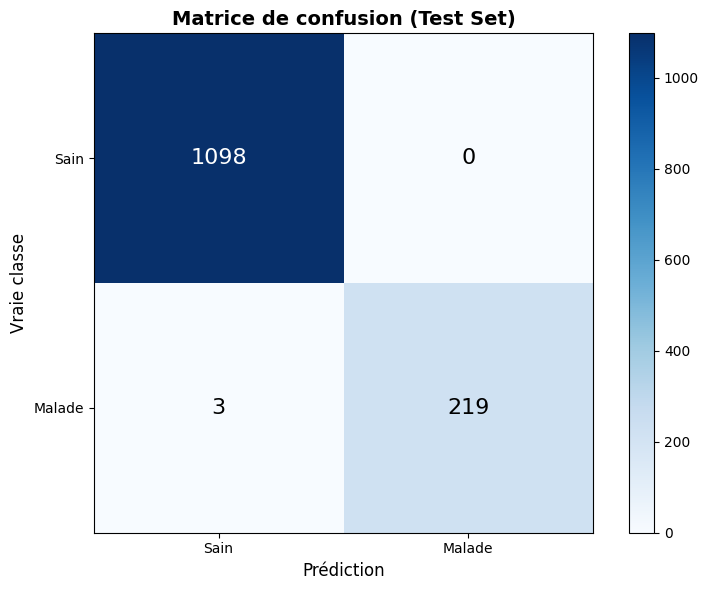

✅ Sauvegardé : confusion_matrix_auto.png
⚠️ Feature importances non disponibles pour ce modèle

RÉSUMÉ
✅ Features automatiques utilisées : 16
✅ Taille du dataset : 6600 vaches
✅ F1-Score Test : 0.9932
✅ ROC-AUC : 0.9987

📁 Fichiers générés :
   • best_model_auto.joblib
   • feature_names_auto.joblib
   • confusion_matrix_auto.png
   • feature_importance_auto.png



In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Détection automatique de mastite bovine
Features: Température + Mesures ultrasoniques uniquement
"""

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, f1_score,
    precision_recall_curve, auc
)
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

# Optionnel : SMOTE pour déséquilibre
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("⚠️ imblearn non disponible – SMOTE désactivé.")

RANDOM_STATE = 42

# ============================================================================
# 1. CHARGEMENT & NETTOYAGE
# ============================================================================
print("=" * 70)
print("DÉTECTION AUTOMATIQUE DE MASTITE - FEATURES AUTOMATIQUES UNIQUEMENT")
print("=" * 70)

df = pd.read_csv("data.csv")
print(f"\n📊 Taille initiale : {df.shape}")
print(f"❌ Valeurs manquantes :\n{df.isnull().sum()}\n")

# Supprimer lignes avec valeurs manquantes
df = df.dropna().reset_index(drop=True)
print(f"✅ Après nettoyage : {df.shape}")

# ============================================================================
# 2. SÉLECTION DES FEATURES AUTOMATIQUES UNIQUEMENT
# ============================================================================
print("\n" + "=" * 70)
print("FEATURES UTILISÉES (DÉTECTION AUTOMATIQUE)")
print("=" * 70)

# ✅ Features détectables automatiquement
AUTO_FEATURES = [
    'Breed',                      # Info disponible (base de données)
    'Months after giving birth',  # Info disponible (base de données)
    'Previous_Mastits_status',    # Historique (base de données)
    'Temperature',                # 🌡️ Capteur thermique
    'IUFL', 'EUFL',              # 🔊 Ultrasons quartier avant-gauche
    'IUFR', 'EUFR',              # 🔊 Ultrasons quartier avant-droit
    'IURL', 'EURL',              # 🔊 Ultrasons quartier arrière-gauche
    'IURR', 'EURR'               # 🔊 Ultrasons quartier arrière-droit
]

# ❌ Features EXCLUES (nécessitent inspection manuelle)
EXCLUDED_FEATURES = [
    'Hardness',          # Palpation manuelle
    'Pain',              # Observation comportementale
    'Milk_visibility'    # Inspection visuelle du lait
]

print("\n✅ Features automatiques retenues :")
for feat in AUTO_FEATURES:
    print(f"   • {feat}")

print("\n❌ Features exclues (détection manuelle) :")
for feat in EXCLUDED_FEATURES:
    print(f"   • {feat}")

# Vérifier disponibilité des features
available_features = [f for f in AUTO_FEATURES if f in df.columns]
missing = set(AUTO_FEATURES) - set(available_features)
if missing:
    print(f"\n⚠️ Features manquantes : {missing}")

# ============================================================================
# 3. PRÉPARATION DES DONNÉES
# ============================================================================
TARGET = "class1"
assert TARGET in df.columns, f"❌ Colonne cible '{TARGET}' introuvable."

# Encodage variables catégorielles
for col in ["Breed", "Previous_Mastits_status"]:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Extraction features et target
X = df[available_features].copy()
y = df[TARGET].copy()

# ============================================================================
# 4. FEATURE ENGINEERING - ASYMÉTRIES ULTRASONIQUES
# ============================================================================
print("\n" + "=" * 70)
print("FEATURE ENGINEERING - ASYMÉTRIES")
print("=" * 70)

# Asymétries entre quartiers internes/externes (indicateur de pathologie)
X['asym_FL'] = np.abs(df.get('IUFL', 0) - df.get('EUFL', 0))
X['asym_FR'] = np.abs(df.get('IUFR', 0) - df.get('EUFR', 0))
X['asym_RL'] = np.abs(df.get('IURL', 0) - df.get('EURL', 0))
X['asym_RR'] = np.abs(df.get('IURR', 0) - df.get('EURR', 0))

print("✅ 4 features d'asymétrie ajoutées (IUFL-EUFL, etc.)")
print(f"📊 Shape finale : {X.shape}")

# ============================================================================
# 5. SPLIT STRATIFIÉ
# ============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("\n" + "=" * 70)
print("DISTRIBUTION DES CLASSES")
print("=" * 70)
print(f"Train : {dict(y_train.value_counts())}")
print(f"Test  : {dict(y_test.value_counts())}")

# ============================================================================
# 6. PIPELINE : PREPROCESSING + MODÈLE
# ============================================================================
numeric_features = X.columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features)
], remainder='drop')

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Pipeline avec ou sans SMOTE
if IMBLEARN_AVAILABLE:
    pipeline = ImbPipeline([
        ("preproc", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", xgb_clf)
    ])
    print("\n✅ Pipeline : Preprocessing → SMOTE → XGBoost")
else:
    pipeline = Pipeline([
        ("preproc", preprocessor),
        ("clf", xgb_clf)
    ])
    print("\n✅ Pipeline : Preprocessing → XGBoost")

# ============================================================================
# 7. OPTIMISATION HYPERPARAMÈTRES
# ============================================================================
print("\n" + "=" * 70)
print("RECHERCHE HYPERPARAMÈTRES (RandomizedSearchCV)")
print("=" * 70)

param_dist = {
    "clf__n_estimators": [100, 150, 250],
    "clf__learning_rate": [0.01, 0.03, 0.05],
    "clf__max_depth": [3, 4, 5],
    "clf__subsample": [0.6, 0.7, 0.8],
    "clf__colsample_bytree": [0.6, 0.7, 0.8],
    "clf__min_child_weight": [1, 3, 5],
    "clf__gamma": [0, 0.5, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("🔍 Démarrage de la recherche (30 itérations)...\n")
rs.fit(X_train, y_train)

print(f"\n✅ Meilleurs paramètres : {rs.best_params_}")
print(f"✅ Meilleur F1-score CV  : {rs.best_score_:.4f}")

best_model = rs.best_estimator_

# ============================================================================
# 8. CALIBRATION DES PROBABILITÉS
# ============================================================================
print("\n" + "=" * 70)
print("CALIBRATION DES PROBABILITÉS")
print("=" * 70)

calibrated = CalibratedClassifierCV(best_model, cv=3, method='isotonic')

try:
    calibrated.fit(X_train, y_train)
    final_model = calibrated
    print("✅ Calibration isotonic réussie")
except Exception as e:
    print(f"⚠️ Calibration échouée : {e}")
    final_model = best_model

# ============================================================================
# 9. ÉVALUATION SUR TEST SET
# ============================================================================
print("\n" + "=" * 70)
print("PERFORMANCE SUR TEST SET")
print("=" * 70)

y_pred = final_model.predict(X_test)

if hasattr(final_model, "predict_proba"):
    y_proba = final_model.predict_proba(X_test)[:, 1]
else:
    y_proba = final_model.decision_function(X_test)
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

print("\n" + classification_report(y_test, y_pred))
print(f"📊 ROC-AUC : {roc_auc_score(y_test, y_proba):.4f}")
print(f"📊 F1-Score : {f1_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred)
print(f"\n📊 Matrice de confusion :\n{cm}")

# PR AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"📊 PR-AUC : {pr_auc:.4f}")

# ============================================================================
# 10. SAUVEGARDE
# ============================================================================
out_path = Path("best_model_auto.joblib")
joblib.dump(final_model, out_path)
print(f"\n💾 Modèle sauvegardé : {out_path}")

# Sauvegarder aussi les noms de features pour l'inférence
feature_names = {
    'features': numeric_features,
    'scaler_fitted': True
}
joblib.dump(feature_names, "feature_names_auto.joblib")
print(f"💾 Features sauvegardées : feature_names_auto.joblib")

# ============================================================================
# 11. VISUALISATIONS
# ============================================================================
print("\n" + "=" * 70)
print("GÉNÉRATION DES GRAPHIQUES")
print("=" * 70)

# Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion (Test Set)', fontsize=14, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Sain', 'Malade'])
plt.yticks(tick_marks, ['Sain', 'Malade'])
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Vraie classe', fontsize=12)

# Annoter la matrice
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black',
                fontsize=16)

plt.tight_layout()
plt.savefig('confusion_matrix_auto.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Sauvegardé : confusion_matrix_auto.png")

# Feature Importances
try:
    clf = final_model
    if hasattr(final_model, "base_estimator_"):
        clf = final_model.base_estimator_
    if hasattr(clf, "named_steps"):
        clf = clf.named_steps.get('clf', clf)

    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        feat_names = numeric_features
        idx = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 8))
        plt.barh([feat_names[i] for i in idx], importances[idx], color='steelblue')
        plt.xlabel('Importance', fontsize=12)
        plt.title('Importance des Features (Détection Automatique)',
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('feature_importance_auto.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Sauvegardé : feature_importance_auto.png")
    else:
        print("⚠️ Feature importances non disponibles pour ce modèle")

except Exception as e:
    print(f"⚠️ Erreur lors de l'affichage des importances : {e}")

# ============================================================================
# 12. RÉSUMÉ FINAL
# ============================================================================
print("\n" + "=" * 70)
print("RÉSUMÉ")
print("=" * 70)
print(f"✅ Features automatiques utilisées : {len(numeric_features)}")
print(f"✅ Taille du dataset : {len(df)} vaches")
print(f"✅ F1-Score Test : {f1_score(y_test, y_pred):.4f}")
print(f"✅ ROC-AUC : {roc_auc_score(y_test, y_proba):.4f}")
print(f"\n📁 Fichiers générés :")
print(f"   • best_model_auto.joblib")
print(f"   • feature_names_auto.joblib")
print(f"   • confusion_matrix_auto.png")
print(f"   • feature_importance_auto.png")
print("\n" + "=" * 70)

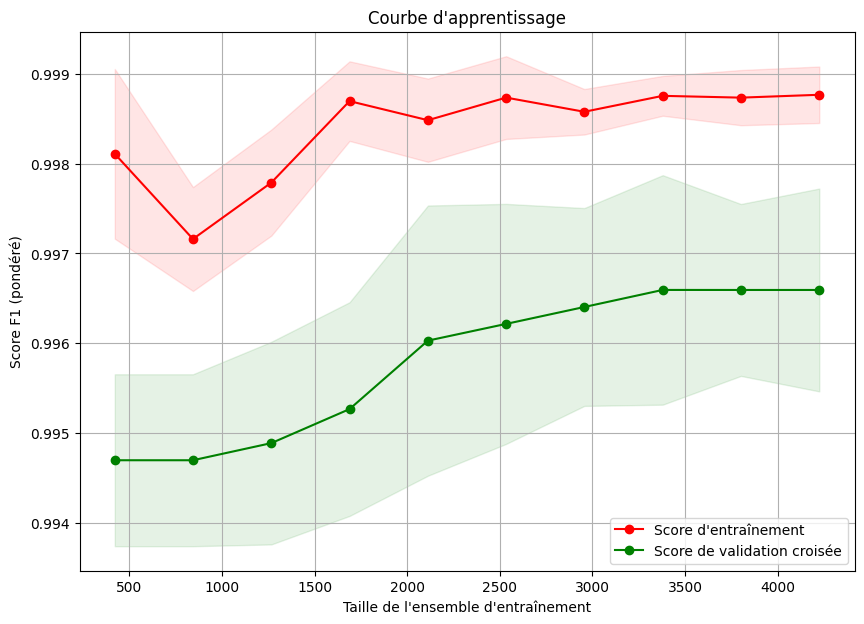

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Get the best estimator from RandomizedSearchCV (before calibration)
# The 'best_model' variable holds the pipeline with preproc, smote (if active), and xgb_clf
estimator = rs.best_estimator_

# Define the training sizes and scoring metric
train_sizes, train_scores, test_scores = learning_curve(
    estimator,
    X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=RANDOM_STATE
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Score de validation croisée")

plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score F1 (pondéré)")
plt.title("Courbe d'apprentissage")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [ ]:
import pickle
from pathlib import Path

# Assuming 'final_model' is your trained model from the previous steps

# Define the path for the .pk file
pk_out_path = Path("best_model_auto.pk")

# Save the model using pickle
with open(pk_out_path, 'wb') as file:
    pickle.dump(final_model, file)

print(f"Modèle sauvegardé au format .pk dans {pk_out_path}")

Modèle sauvegardé au format .pk dans best_model_auto.pk


In [ ]:
import pickle
from pathlib import Path

# Define the path to load the .pk file from
pk_out_path = Path("best_model_auto.pk")

# Load the model from the .pk file
with open(pk_out_path, 'rb') as file:
    loaded_pk_model = pickle.load(file)

print(f"Modèle chargé depuis {pk_out_path}")

# You can now use 'loaded_pk_model' for predictions or further evaluation
# For example, to check its type:
print(f"Type du modèle chargé : {type(loaded_pk_model)}")

Modèle chargé depuis best_model_auto.pk
Type du modèle chargé : <class 'sklearn.calibration.CalibratedClassifierCV'>


In [ ]:
import sklearn
import imblearn
import numpy as np
import pandas as pd

print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)


scikit-learn: 1.6.1
imbalanced-learn: 0.14.0
numpy: 2.0.2
pandas: 2.2.2
